In [1]:
!pip install imbalanced-learn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install turicreate --ignore-installed
!pip install turicreate --user
!pip install turicreate

     |████████████████████████████████| 92.0 MB 63.5 MB/s 
     |████████████████████████████████| 3.5 MB 47.7 MB/s 
     |████████████████████████████████| 3.6 MB 32.1 MB/s 
     |████████████████████████████████| 18.3 MB 31.1 MB/s 
     |████████████████████████████████| 14.8 MB 12.3 MB/s 
     |████████████████████████████████| 9.9 MB 25.1 MB/s 
     |████████████████████████████████| 2.2 MB 58.1 MB/s 
     |████████████████████████████████| 1.0 MB 42.7 MB/s 
     |████████████████████████████████| 227 kB 50.9 MB/s 
     |████████████████████████████████| 510 kB 39.6 MB/s 
     |████████████████████████████████| 61 kB 3.6 MB/s 
     |████████████████████████████████| 147 kB 46.5 MB/s 
     |████████████████████████████████| 178 kB 52.0 MB/s 
     |████████████████████████████████| 58 kB 2.9 MB/s 
     |████████████████████████████████| 322 kB 48.0 MB/s 
     |████████████████████████████████| 27.4 MB 14.8 MB/s 
     |████████████████████████████████| 784 kB 30.0 MB/s 
     |████████

In [3]:
from __future__ import division
import turicreate 

In [4]:
train = turicreate.SFrame.read_csv('../input/alc-datathon-2021/covid_mental_health_train.csv')

Finished parsing file /kaggle/input/alc-datathon-2021/covid_mental_health_train.csv

Parsing completed. Parsed 100 lines in 0.055361 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /kaggle/input/alc-datathon-2021/covid_mental_health_train.csv

Parsing completed. Parsed 8610 lines in 0.044971 secs.

In [5]:
test = turicreate.SFrame.read_csv('../input/alc-datathon-2021/covid_mental_health_test.csv')
len(test)

Finished parsing file /kaggle/input/alc-datathon-2021/covid_mental_health_test.csv

Parsing completed. Parsed 100 lines in 0.032765 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /kaggle/input/alc-datathon-2021/covid_mental_health_test.csv

Parsing completed. Parsed 2723 lines in 0.030041 secs.

2723

In [6]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [7]:
important_words = ['current_mental', 'past_mental', 'past_physical', 'current_physical', 'optimism', 'deterioration_interact', 'frustration', 'difficulty_work', 'difficulty_living', 'deterioration_economy', 'healthy_sleep']
feature_matrix_train, sentiment_train = get_numpy_data(train, important_words, 'depression')

In [8]:
print(len(feature_matrix_train))

8610


In [9]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [10]:
undersample = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X_under, y_under = undersample.fit_resample(feature_matrix_train, sentiment_train)
# summarize class distribution
print(Counter(y_under))

Counter({0: 3108, 1: 1554})


In [11]:
print(len(X_under))

4662


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_X, val_X, train_y, val_y = train_test_split(X_under, y_under, test_size=0.2)

In [14]:
print(len(train_X))
print(len(val_X))

3729
933


In [15]:
print(val_y.shape)

(933,)


In [16]:
import math

In [17]:
def predict_probability(feature_matrix, coefficients):
    w_h_x = np.dot(feature_matrix, coefficients)
    predictions = 1/(1 + np.exp(-w_h_x))
    return predictions

In [18]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant):
    derivative = np.dot(errors, feature)
    if not feature_is_constant:
        derivative = derivative - 2*l2_penalty*coefficient
    return derivative

In [19]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [20]:
from math import sqrt

def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients)
    for itr in range(max_iter):
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==+1)
        errors = indicator - predictions
        for j in range(len(coefficients)):
            is_intercept = (j == 0)
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            coefficients[j] = coefficients[j] + step_size*derivative
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [21]:
coefficients_4_penalty = logistic_regression_with_L2(train_X, train_y,
                                                     initial_coefficients=np.zeros(12),
                                                     step_size=5e-6, l2_penalty=4, max_iter=100)

iteration  0: log likelihood of observed labels = -2447.47632641
iteration  1: log likelihood of observed labels = -2409.20519283
iteration  2: log likelihood of observed labels = -2389.79267242
iteration  3: log likelihood of observed labels = -2374.70108262
iteration  4: log likelihood of observed labels = -2361.01623170
iteration  5: log likelihood of observed labels = -2348.09687093
iteration  6: log likelihood of observed labels = -2335.78058365
iteration  7: log likelihood of observed labels = -2324.01032237
iteration  8: log likelihood of observed labels = -2312.75329991
iteration  9: log likelihood of observed labels = -2301.98303238
iteration 10: log likelihood of observed labels = -2291.67532864
iteration 11: log likelihood of observed labels = -2281.80737978
iteration 12: log likelihood of observed labels = -2272.35753386
iteration 13: log likelihood of observed labels = -2263.30521838
iteration 14: log likelihood of observed labels = -2254.63089295
iteration 15: log likelih

In [22]:
coefficients_4_penalty

array([-0.03265762, -0.11121046, -0.11392448, -0.07311726, -0.07088027,
       -0.20876685,  0.14153336,  0.15192911,  0.05787599,  0.05454658,
        0.06414075, -0.18503555])

In [23]:
scores = np.dot(train_X,coefficients_4_penalty)
for i in range(0, len(scores)-1):
    print(scores[i])

-1.1155649442671292
0.1681593695881669
-1.7366703925398934
-0.010819669390015274
-0.4298518952518165
-0.05428678992176367
-0.024764017780434133
0.23221062500437673
-0.46619979931563577
-1.2940729755415983
-1.4256885172937008
-0.4660290262086977
-0.7835610714928068
-0.7032064167856742
-0.33559255775794294
-2.3134109643165726
-0.5844620931062503
-0.060082678819643354
-0.7682309484648904
-0.4808761568530641
0.25117027029460165
0.4883963004558005
0.5410402346295351
-1.1068518986411826
0.18276319338441083
0.843766782806588
1.5908412481032457
0.9635750024202032
-0.28838016995899907
0.034557773008362824
-1.1790192387367338
-0.5334991828673246
-0.05377348741787402
0.595122995174892
-0.7019261613471678
-1.4200679820608895
-1.8821153863286137
-1.288032451619345
-0.9569256398503799
-0.6584512673150292
-1.7548204848658369
-0.1957992208042061
-0.7392405209788885
-0.7303807014649469
-0.7013841517350452
-1.0569496108969652
-0.3618420681147331
-1.0807822383661803
0.857592427174669
-1.3254675022656608


In [24]:
prediction = predict_probability(val_X, coefficients_4_penalty)
prediction

array([0.30610685, 0.29235571, 0.24534479, 0.22831744, 0.1880816 ,
       0.59922091, 0.47932785, 0.42211431, 0.6223791 , 0.19914177,
       0.16609382, 0.54479386, 0.28185577, 0.56857963, 0.13627466,
       0.20711639, 0.22835005, 0.10736956, 0.21007502, 0.69615945,
       0.07825096, 0.27897757, 0.28593757, 0.50330354, 0.32147114,
       0.50141646, 0.25782584, 0.17336869, 0.21496646, 0.54758675,
       0.47685502, 0.37643275, 0.51158778, 0.40443586, 0.51713617,
       0.08712364, 0.35777772, 0.42053771, 0.21069581, 0.46602606,
       0.38453271, 0.35844848, 0.40762231, 0.7184995 , 0.38697543,
       0.41483517, 0.05474614, 0.22339288, 0.39910075, 0.52808492,
       0.63254554, 0.31366421, 0.72043561, 0.20085964, 0.51029608,
       0.37416907, 0.19648353, 0.68755622, 0.74250819, 0.28282643,
       0.31970587, 0.45165424, 0.48614478, 0.58496543, 0.14416115,
       0.18753155, 0.08935257, 0.28968561, 0.43017381, 0.37884435,
       0.30053951, 0.20855898, 0.51687322, 0.45075079, 0.32174

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
def accuracy_plots(y_score, plot_name, y_true=[int(i) for i in val_y]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    close_zero = np.argmin(np.abs(thresholds))
    roc_auc = roc_auc_score(y_true, y_score)
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    close_zero_pr = np.argmin(np.abs(thresholds_pr))
    
    fig, ax = plt.subplots(2, 1, figsize=(12,14), sharex=True)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15, top=0.93)
    fig.suptitle(plot_name, fontsize=14)
    ax[0].plot(fpr, tpr, 'b', label='AUC %0.2f' % roc_auc)
    ax[0].plot(fpr[close_zero], tpr[close_zero], 'o', markersize=12, label="threshold zero", fillstyle="none", c='r', mew=2)
    ax[0].plot([(0,0),(1,1)], c='r', linestyle='--')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_xlim([0,1])
    ax[0].set_ylim([0,1])
    ax[0].legend(loc=4)
    ax[0].set_title('ROC Curve')
    ax[1].plot(precision, recall, 'b')
    ax[1].plot(precision[close_zero_pr], recall[close_zero_pr], 'o', markersize=12, label="threshold zero", fillstyle="none", c='r', mew=2)
    ax[1].set_ylabel('Recall')
    ax[1].set_xlabel('Precision')
    ax[1].set_title('Precision Recall Curve')
    ax[1].legend(loc=4)
    plt.show()

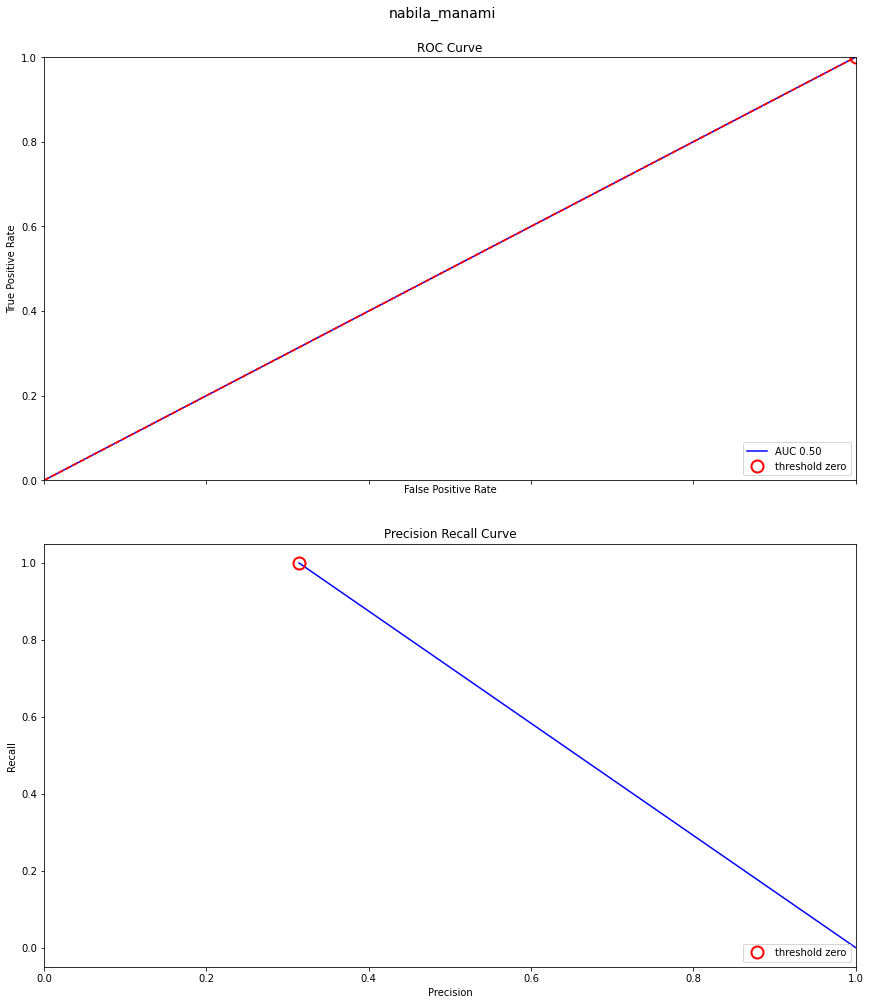

In [26]:
accuracy_plots([int(i) for i in prediction], 'nabila_manami', y_true=[int(i) for i in val_y])

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
print(roc_auc_score(val_y, prediction))

0.7387851962457338


In [28]:
def get_numpy_data_test(data_sframe, features):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    return feature_matrix

In [29]:
feature_test_matrix = get_numpy_data_test(test, important_words)

In [30]:
#prediction_test

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
#print(roc_auc_score(sentiment_train, prediction_test))

In [32]:
def get_numpy_data_pred_train(data_sframe, label):
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return label_array

In [33]:
#sentiment_train = get_numpy_data_pred_train(train, 'depression')
prediction_test = predict_probability(feature_test_matrix, coefficients_4_penalty)
val_pred = predict_probability(val_X, coefficients_4_penalty)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
print(roc_auc_score(val_y, val_pred))

0.7387851962457338


In [34]:
import pandas as pd

In [35]:
submission_new = turicreate.SFrame({'depression':prediction_test, 'id':test['id']})

In [36]:
abs = submission_new.export_csv('sunami.csv')